In [21]:
import collections
import time
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import networkx as nx
import graph_tool.all as gt

import cc_graph_ops

In [2]:
INPUT_FILE = 'fdg_input_file.json'

In [3]:
g = cc_graph_ops.create_graph_from_file(INPUT_FILE, format='gt')

In [4]:
# Overflow for 32-bit ints
weight_long = g.ep['weight'].copy(value_type='long')

In [5]:
coef, stdev = gt.global_clustering(g, weight=weight_long)

In [6]:
coefs, stdevs = dict(), dict()

coefs['all'] = coef
stdevs['all'] = stdev

In [7]:
quota = 10
proportion = 0.3
min_subgraph_size = 100

In [8]:
licenses = list(cc_graph_ops.get_licenses(g))
subgraphs = cc_graph_ops.all_license_subgraphs(g, licenses, quota=quota, proportion=proportion)

In [9]:
for license, subg in subgraphs.items():
    if subg.num_vertices() < min_subgraph_size:
        continue
    coef, stdev = gt.global_clustering(subg, weight=weight_long)
    coefs[license] = coef
    stdevs[license] = stdev

In [10]:
size = {license: subg.num_vertices() for license, subg in subgraphs.items()}
size['all'] = g.num_vertices()

In [11]:
keys = list(coefs.keys())
keys.sort(key=lambda x: -coefs[x])

In [19]:
density = {}
for license, subg in subgraphs.items():
    if subg.num_vertices() > 1:
        e = subg.num_edges()
        v2 = scipy.special.binom(subg.num_vertices(), 2)
        density[license] = e/v2
density['all'] = g.num_edges() / scipy.special.binom(g.num_vertices(), 2)

In [20]:
table = [[k, size[k], coefs[k], density[k]] for k in keys]
global_clustering_df = pd.DataFrame(table, columns=['License', 'Size', 'Clustering', 'Density'])
global_clustering_df = global_clustering_df.set_index('License')
display(global_clustering_df)

,Size,Clustering,Density
License,,,
"('by-nc-sa', '2.5')",1118,0.793559,0.001823
"('by-sa', '3.0')",6514,0.601791,0.001737
all,235863,0.440094,0.000149
"('cc0', '1.0')",893,0.410368,0.003329
"('by-nc-nd', '4.0')",7387,0.404350,0.000408
"('by', '3.0')",5722,0.403254,0.000734
"('by-nd', '4.0')",629,0.328749,0.001327
"('by-sa', '4.0')",7066,0.323638,0.000879
"('by', '4.0')",9085,0.278524,0.001480


We see that some licenses are much more more clustered than others -- BY-NC-SA 2.5 and BY-SA 3.0 are quite a bit higher than everything else, and CC0 1.0, BY-NC-ND 4.0, and BY 3.0 are also quite high.

<AxesSubplot:xlabel='Density', ylabel='Clustering'>

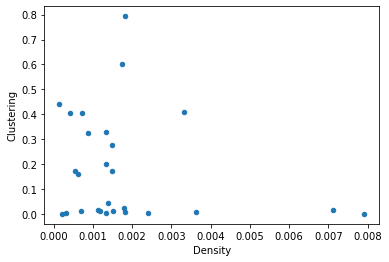

In [23]:
global_clustering_df.plot.scatter('Density', 'Clustering')

There is little correlation between the clustering coefficient and the density of the graph, showing that the tendency to cluster is a property of the license graph itself rather than due to random chance.

In [27]:
local_coefs = dict()
for license in coefs:
    if license != 'all':
        local_clusters = gt.local_clustering(subgraphs[license], weight=weight_long)
        local_clusters = {v: local_clusters[v] for v in subgraphs[license].vertices()}
        local_clusters = sorted(list(local_clusters.items()), key=lambda x: -x[1])
        local_coefs[license] = local_clusters

In [28]:
for license in global_clustering_df.index:
    if license != 'all':
        print(license, global_clustering_df.loc[license, 'Clustering'])
        data = []
        for v, coef in local_coefs[license][:10]:
            data.append([subgraphs[license].vp['provider_domain'][v], coef])
        display(pd.DataFrame(data, columns=['Domain', 'Clustering']))
        print()

('by-nc-sa', '2.5') 0.7935592444906805


,Domain,Clustering
0,shun.im,218.000000
1,www.qiusi.me,72.666667
2,www.surveillanceincanada.org,36.000000
3,pochistvane.com,21.619565
4,www.xj123.info,16.769231
5,www.danielgarciaperis.cat,15.912334
6,praxis.tw,12.285714
7,xn--czq75pvv1aj5c.org,9.750000
8,felixc.at,9.333333
9,blog.imprenditore.me,6.914286



('by-sa', '3.0') 0.6017905751196228


,Domain,Clustering
0,contentedness.net,2.081500e+07
1,50days.org,2.081500e+07
2,www.linke-piraten-hd.de,2.081500e+07
3,hejlt.org,1.040750e+07
4,enskedebilder.com,1.040750e+07
5,www.infoturia.com,6.938334e+06
6,www.daemmen-und-sanieren.de,6.938334e+06
7,fortunengineering.com,6.938334e+06
8,www.adhugger.net,6.938334e+06
9,geschichtskasten.kastenwesen.com,5.203764e+06



('cc0', '1.0') 0.4103683368256483


,Domain,Clustering
0,wiki.ms.agh.edu.pl,25790.333333
1,ariadne.uni-greifswald.de,3975.766667
2,data.nola.gov,2316.800000
3,da.dl.itc.u-tokyo.ac.jp,2183.380102
4,data.southampton.ac.uk,1490.361111
5,ehsanakhgari.org,1435.000000
6,risdmuseum.org,1125.065574
7,tudigit.ulb.tu-darmstadt.de,648.800500
8,parismuseescollections.paris.fr,487.120477
9,robustlybeneficial.org,450.992369



('by-nc-nd', '4.0') 0.404350249377385


,Domain,Clustering
0,www.elphis.or.kr,912178.000000
1,www.chefstyle.co.kr,912178.000000
2,www.meistercom.com,456089.000000
3,openeg.co.kr,456089.000000
4,wacomkoreablog.com,456089.000000
5,nerd.kr,304161.333333
6,enternews1.com,182435.600000
7,innanum.org,182435.600000
8,blog.hwenc.co.kr,136867.700000
9,volunteeringculture.or.kr,114022.250000



('by', '3.0') 0.40325441864045214


,Domain,Clustering
0,hronlineph.com,36658.333333
1,africommons.com,8729.657143
2,desculpeanossafalha.com.br,4982.216162
3,dallas.libertarianleft.org,3111.000000
4,www.stembook.org,1989.000000
5,thenetmonitor.org,1814.871029
6,advox.it,1533.711297
7,www.socialbrite.org,1423.755260
8,www.periodicos.ufn.edu.br,1136.944444
9,www.fmwic.com,979.548387



('by-nd', '4.0') 0.3287485837530737


,Domain,Clustering
0,journals.squ.edu.om,101.200000
1,quoimedia.com,38.000000
2,yellowfever.com.au,36.066667
3,bizkai.eus,22.705552
4,travelhealthpolicy.com.au,20.415094
5,derbreitenbacher.de,12.809524
6,www.siegen-wittgenstein.info,7.915916
7,singularityhub.com,7.838710
8,www.pnvnafarroa.eus,3.534815
9,sitio.fdsl.org.do,3.438403



('by-sa', '4.0') 0.32363769772268114


,Domain,Clustering
0,blog.tommyku.com,4.000048e+07
1,www.swalladge.net,1.333390e+07
2,awtfy.com,1.000030e+07
3,guillaume-chevalier.com,1.000022e+07
4,blog.mitsuruog.info,1.000012e+07
5,smlpoints.com,8.000118e+06
6,www.8u.co.kr,8.000096e+06
7,www.chunyangwen.com,8.000096e+06
8,lucisferre.net,8.000096e+06
9,www.kyleondy.com,6.667246e+06



('by', '4.0') 0.27852419549229096


,Domain,Clustering
0,radonjournal.net,439516.066667
1,tianqi.name,131824.000000
2,cryo.org.ua,127449.200000
3,felixwong.com,93291.212308
4,habricentral.org,93237.733333
5,journals.scholarpublishing.org,85599.963235
6,www.mozello.co.uk,84804.725146
7,www.cargill.school.nz,80746.952381
8,www.saferoptions.org,74745.787879
9,nachhaltig-beleuchten.de,74623.190476



('by-nc-nd', '2.5') 0.1991532284616921


,Domain,Clustering
0,www.mindsfree.info,3385.666667
1,www.a6fanzine.it,2067.333333
2,www.francescouboldi.com,1977.333333
3,www.emergenzautismo.org,1157.464286
4,www.valentano.net,1050.233333
5,max510.com,988.700000
6,www.ildottoredeicomputer.com,985.606061
7,www.scienzenoetiche.it,791.000000
8,metalskunk.com,619.403333
9,www.aetnanet.org,545.085714



('by-nc-sa', '2.0') 0.17113967154967388


,Domain,Clustering
0,rdl.de,1814.333333
1,talkingheads.net,536.517241
2,secant.cs.purdue.edu,420.866667
3,journalatelier.com,318.000000
4,www.lafibala.org,202.361111
5,notremetier.se-unsa.org,161.890909
6,www.cse.cuhk.edu.hk,105.380952
7,nicolas.picand.fr,93.000000
8,awiki.theseed.io,91.691168
9,www.marcguidoni.fr,91.085714



('by-nc', '4.0') 0.17038576946281686


,Domain,Clustering
0,smeru.or.id,24626.333333
1,ccdemocraticas.net,4750.333333
2,www.oneducation.net,4702.672727
3,www.iberoamericana.se,4397.700000
4,rcm.insmet.cu,4397.666667
5,ojs.gayanabotanica.cl,3878.000000
6,revistamedicasinergia.com,2250.800000
7,erevistas.uacj.mx,2199.357143
8,sustain.pata.org,1522.435435
9,seer.ufsj.edu.br,1296.410256



('by-nc-sa', '3.0') 0.16198905644013484


,Domain,Clustering
0,www.progettodighe.it,24293.476190
1,michaeljcripps.com,2080.000000
2,www.windowswiki.info,1692.000000
3,kenliu.name,830.033333
4,biblioteca.fundaciopalau.cat,521.866667
5,www.csadepistaggio.org,486.000000
6,voyez.ca,457.481476
7,www.konjunktion.info,375.153846
8,beziaud.org,357.734127
9,wikimerda.org,353.115516



('by-nd', '3.0') 0.04323249151810079


,Domain,Clustering
0,www.ladikvetvicka.cz,2391.000000
1,www.ufac.br,516.978022
2,acervo.ufvjm.edu.br,81.205263
3,radek-velicka.cz,79.700000
4,www.novo.justica.gov.br,30.764977
5,www.ibametro.ba.gov.br,13.791395
6,www.tecnopolo.it,13.600000
7,seplan.ba.gov.br,8.130824
8,www.fpc.pt,8.026863
9,revista.ibict.br,6.384384



('by-nc', '2.0') 0.022298638973056988


,Domain,Clustering
0,aspb-rta.secure-platform.com,153.325216
1,phenome2020.org,111.419612
2,www.timbres-bordeaux.fr,7.443192
3,album-timbres.fr,4.930547
4,docteurhtml5.com,2.177742
5,lasikuu.net,1.473684
6,kasvukipuja.net,0.875000
7,marcophilie.france-timbres.net,0.599999
8,www.marcophilie.e-timbres.net,0.586445
9,www.planchage-timbres.fr,0.362091



('gpl', '2.0') 0.014264716486049621


,Domain,Clustering
0,www.iwp.jku.at,1044.182698
1,www.right2info.org,378.166667
2,www.cae.tntech.edu,281.070875
3,portal.metodista.br,162.545455
4,libraryguides.griffith.edu.au,143.305263
5,www.ictp.tv,96.818182
6,www2.rpgfund.org,90.245355
7,cmstest.ifac-control.org,87.277092
8,www2.spokaneasl.com,76.766513
9,download.zope.org,73.026169



('by-nc', '3.0') 0.013891561750649074


,Domain,Clustering
0,heritage.nzei.org.nz,12378.666667
1,e-pub.uni-weimar.de,1642.533333
2,www.nzonscreen.com,96.157986
3,seguridad.observatoriofundapro.com,94.400000
4,imagesdutravail.edel.univ-poitiers.fr,87.522876
5,ajme.aut.ac.ir,67.100613
6,www.smarty.com.es,42.966667
7,boundforsouthaustralia.com.au,42.285714
8,bryophyteportal.org,23.397740
9,desitkapomaha.cz,21.916337



('by-nc-nd', '3.0') 0.01158709239008921


,Domain,Clustering
0,ayumihorie.com,42647.666667
1,www.albrecht-durer.org,42619.000000
2,godinci.org,42619.000000
3,www.askasu.idv.tw,38766.666667
4,www.recreathing.com,31964.200000
5,www.farflungfamilies.net,31964.200000
6,www.yesbutnobutyes.com,28533.700000
7,pinkskulldesign.com,28533.700000
8,www.alma-tadema.org,25589.400000
9,www.plantprotection.pl,21325.333333



('by-nc-nd', '2.0') 0.010806048844987766


,Domain,Clustering
0,www.aureliablogmode.com,997.000000
1,www.linaudible.com,544.000000
2,www.sistoeurs.net,498.333333
3,meiz.me,226.883092
4,www.aquarelle-en-liberte.fr,199.400000
5,koinai.net,135.357143
6,www.gasengi.com,93.922481
7,tournevis.net,92.800000
8,www.estceque.org,76.692308
9,www.fredorando.fr,52.473684



('by-sa', '2.0') 0.010649647971143237


,Domain,Clustering
0,bb.mehr-demokratie.de,271.000000
1,geektionnerd.net,78.372549
2,grisebouille.net,77.666667
3,ourjourneypeterborough.org,44.553258
4,irfm.regardscitoyens.org,43.528455
5,peirce.gis-lab.info,33.014259
6,www.nanterrux.org,24.362637
7,www.migazin.de,21.363636
8,www.closedpubs.co.uk,19.966079
9,blog.roozeec.fr,17.111111



('by-nc', '2.5') 0.008382192822623676


,Domain,Clustering
0,playstationblast.forumbrasil.net,61.393443
1,www.corridorkitchen.com,2.606557
2,onebitemore.com,0.317365
3,www.raspberricupcakes.com,0.042654
4,media.mcgill.ca,0.012821
5,www.icebreaker.com.br,0.010621
6,forum.nintendoblast.com.br,0.005793
7,www.infoarena.ro,0.000557
8,xkcd.com,0.000006
9,thinkdo.se,0.000000



('by-sa', '2.5') 0.007628377551355449


,Domain,Clustering
0,www.stubbornmule.net,119.181818
1,blog.fogus.me,19.500000
2,hlds.pl,6.905526
3,buildingaudio.com,4.447619
4,secondlifeshrink.com,3.333333
5,webnovedad.com,3.000000
6,ar.globedia.com,2.160173
7,openfonts.hagilda.com,1.941176
8,devenirgenial.fr,1.466946
9,pourquoidieu.fr,1.445655



('by', '2.5') 0.004017385348822739


,Domain,Clustering
0,www.mp.se,2598.545455
1,maicelular.com,317.000000
2,www.saltedhash.co.il,317.000000
3,coffee3.org,127.833333
4,blog.syafril.com,63.400000
5,www.circ-ien-andolsheim.ac-strasbourg.fr,29.000000
6,tasglann.reefnet.co.uk,20.000000
7,www.stylius.net,19.208791
8,svtcobergher.fr,13.071429
9,blog.foolip.org,12.970760



('by', '2.0') 0.0035473412391762186


,Domain,Clustering
0,szwinsurance.com,1823.000000
1,www.ukauthority.com,1217.700000
2,www.netfrag.org,719.000000
3,rfdinsurance.com,607.666667
4,accentfginsurance.com,607.666667
5,terryins.com,455.700000
6,rlsullivaninsurance.com,455.700000
7,mummainsurance.com,455.700000
8,omega-financial.com,455.700000
9,cantonbecker.com,439.000000



('by-nc-sa', '4.0') 0.003095672064132717


,Domain,Clustering
0,www.pcihispano.com,15005.892857
1,volatilesystems.org,8753.125000
2,textilegeschichten.net,5016.109091
3,botons.eu,3654.000000
4,www.lapsusmentis.com,3153.666667
5,ojs.correspondenciasyanalisis.com,1759.294872
6,etherboot.org,1480.283333
7,stinpriza.org,1227.259259
8,www.pedagomosaique.com,1042.357143
9,www.teawiki.net,915.418776



('pdm', '1.0') 0.001155464633078091


,Domain,Clustering
0,www.europeana.eu,6.426225
1,www.jugendhilfeportal.de,2.385621
2,dija.faktor-e.domainfactory-kunde.de,0.166358
3,biblioteca.galiciana.gal,0.098662
4,www.edu.xunta.gal,0.092572
5,m.dija.de,0.081716
6,fdanj.nlm.nih.gov,0.039724
7,cartotecadigital.icgc.cat,0.000739
8,cartotecadigital.icc.cat,0.000554
9,openimages.eu,0.000438



('by-nd', '2.0') 0.0


,Domain,Clustering
0,freerepublic.com,0.0
1,www.teemingbrain.com,0.0
2,clubdumillenaire.fr,0.0
3,www.zakon-pritazlivosti.cz,0.0
4,uncontrollinglove.com,0.0
5,davidcantone.com,0.0
6,www.livewritethrive.com,0.0
7,www.reha-trans.fr,0.0
8,semeunacte.com,0.0
9,www.empire-of-books.com,0.0


In [77]:
licenses = cc_graph_ops.get_licenses(g)
license_groups = collections.defaultdict(list)
for license in licenses:
    group = license[2:license.find("',")]
    license_groups[group].append(license)

In [ ]:
group_clustering_table = []
group_subgraphs = dict()
for group, licenses in license_groups.items():
    nodes = g.new_vp('bool')
    for v in g.vertices():
        nodes[v] = False
        cc_licenses = g.vp['cc_licenses'][v]
        if isinstance(cc_licenses, dict):
            total_licenses = sum(cc_licenses.values())
            for license in licenses:
                nodes[v] |= (license in cc_licenses
                    and cc_licenses[license] >= proportion * total_licenses
                    and cc_licenses[license] >= quota)
    subg = gt.GraphView(g, vfilt=nodes)
    if subg.num_vertices() > min_subgraph_size:
        group_subgraphs[group] = subg
        coef, stdev = gt.global_clustering(subg, weight=weight_long)
        group_clustering_table.append([group, subg.num_vertices(), coef])

by-nc-sa
by-nd
by-nc-nd
by-nc
by-sa
by
cc0


In [84]:
group_clustering_df = pd.DataFrame(group_clustering_table, columns=['License', 'Size', 'Clustering'])
group_clustering_df = group_clustering_df.set_index('License')
group_clustering_df.sort_values('Clustering', inplace=True, ascending=False)
group_clustering_df

,Size,Clustering
License,,
by-sa,15619,0.440339
cc0,893,0.410368
by,19189,0.194657
by-nd,1610,0.140381
by-nc,5814,0.087801
gpl,409,0.014265
by-nc-nd,17221,0.011197
by-nc-sa,17233,0.004813
pdm,113,0.001155


In [89]:
for group in group_clustering_df.index:
    subg = group_subgraphs[group]
    print(group)
    local_clustering_table = []
    local_clustering_coefs = gt.local_clustering(subg, weight=weight_long)
    for v in subg.vertices():
        v_id = subg.vp['provider_domain'][v]
        local_clustering_table.append([v_id, local_clustering_coefs[v]])
    local_clustering_table.sort(key=lambda x: -x[1])
    local_clustering_df = pd.DataFrame(local_clustering_table[:10], columns=['Domain', 'Clustering'])
    display(local_clustering_df.iloc[:10, :])

by-sa


,Domain,Clustering
0,contentedness.net,2.081500e+07
1,50days.org,2.081500e+07
2,immersive-technology-healthcare.hcs-pharma.com,2.081500e+07
3,www.linke-piraten-hd.de,2.081500e+07
4,gruene-urbach.de,2.081500e+07
5,dwoll.de,1.333356e+07
6,www.the24hourmommy.com,1.040750e+07
7,hejlt.org,1.040750e+07
8,almanach.meteo01.fr,1.040750e+07
9,enskedebilder.com,1.040750e+07


cc0


,Domain,Clustering
0,wiki.ms.agh.edu.pl,25790.333333
1,ariadne.uni-greifswald.de,3975.766667
2,data.nola.gov,2316.800000
3,da.dl.itc.u-tokyo.ac.jp,2183.380102
4,data.southampton.ac.uk,1490.361111
5,ehsanakhgari.org,1435.000000
6,risdmuseum.org,1125.065574
7,tudigit.ulb.tu-darmstadt.de,648.800500
8,parismuseescollections.paris.fr,487.120477
9,robustlybeneficial.org,450.992369


by


,Domain,Clustering
0,radonjournal.net,439516.066667
1,iobaka.com,203893.000000
2,www.biosino.org,195874.115385
3,www.web2py.com,133780.622222
4,tianqi.name,131824.000000
5,habricentral.org,93237.733333
6,internationaljournalofcaringsciences.org,64093.866667
7,cofemsocialchange.org,58593.444444
8,nachhaltig-beleuchten.de,55996.107143
9,journals.scholarpublishing.org,55436.347619


by-nd


,Domain,Clustering
0,dwaves.org,11791.111111
1,www.clamav.net,6289.600000
2,thedndsanctuary.eu,3930.361111
3,www.ladikvetvicka.cz,2391.000000
4,gapil.gnulinux.it,1084.241379
5,marco.nouveausiteweb.fr,792.330239
6,www.linuxzasve.com,551.631579
7,www.ufac.br,516.978022
8,600800.xyz,100.780358
9,www.labath.info,100.488218


by-nc


,Domain,Clustering
0,smeru.or.id,24626.333333
1,www.iberoamericana.se,8109.333333
2,heritage.nzei.org.nz,6610.357143
3,erevistas.uacj.mx,5854.066667
4,rcm.insmet.cu,4397.666667
5,www.oneducation.net,3919.136364
6,ojs.gayanabotanica.cl,3878.000000
7,seer.ufsj.edu.br,2779.087912
8,www.conasi.eu,2300.945455
9,revistamedicasinergia.com,1883.696970


gpl


,Domain,Clustering
0,www.iwp.jku.at,1044.182698
1,www.right2info.org,378.166667
2,www.cae.tntech.edu,281.070875
3,portal.metodista.br,162.545455
4,libraryguides.griffith.edu.au,143.305263
5,www.ictp.tv,96.818182
6,www2.rpgfund.org,90.245355
7,cmstest.ifac-control.org,87.277092
8,www2.spokaneasl.com,76.766513
9,download.zope.org,73.026169


by-nc-nd


,Domain,Clustering
0,www.elphis.or.kr,912178.000000
1,www.chefstyle.co.kr,912178.000000
2,openeg.co.kr,456089.000000
3,nerd.kr,304161.333333
4,textnews.co.kr,259826.000000
5,afrohair.es,246735.333333
6,innanum.org,182435.600000
7,www.itsgom.com,173217.333333
8,enternews1.com,167463.190476
9,kickthecompany.com,92255.923077


by-nc-sa


,Domain,Clustering
0,lady-snowblood.net,912151.333333
1,www.gametopaz.com,532088.277778
2,intelligius.com,407442.333333
3,gbf.wiki,298526.109091
4,chrisssims.com,182480.244444
5,www.gwiki.fr,49578.989130
6,starbounder.org,34349.700254
7,common.wjghj.cn,29905.184445
8,ir.kib.ac.cn,18634.000000
9,research.bowdoin.edu,13392.083696


pdm


,Domain,Clustering
0,www.europeana.eu,6.426225
1,www.jugendhilfeportal.de,2.385621
2,dija.faktor-e.domainfactory-kunde.de,0.166358
3,biblioteca.galiciana.gal,0.098662
4,www.edu.xunta.gal,0.092572
5,m.dija.de,0.081716
6,fdanj.nlm.nih.gov,0.039724
7,cartotecadigital.icgc.cat,0.000739
8,cartotecadigital.icc.cat,0.000554
9,openimages.eu,0.000438
